Saving heart_selected_features_final.csv to heart_selected_features_final.csv
Dataset shape: (229, 5)
Class distribution:
 target
1    133
0     96
Name: count, dtype: int64
Training samples: 183
Testing samples: 46

=== SVM Hyperparameter Tuning ===
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Score (F1): 0.859966749224282

=== SVM Performance (Test Set) ===
Accuracy: 0.8260869565217391
Precision: 0.8518518518518519
Recall: 0.8518518518518519
F1 Score: 0.8518518518518519
ROC AUC: 0.8343079922027291

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.79      0.79      0.79        19
     Disease       0.85      0.85      0.85        27

    accuracy                           0.83        46
   macro avg       0.82      0.82      0.82        46
weighted avg       0.83      0.83      0.83        46



<Figure size 800x600 with 0 Axes>

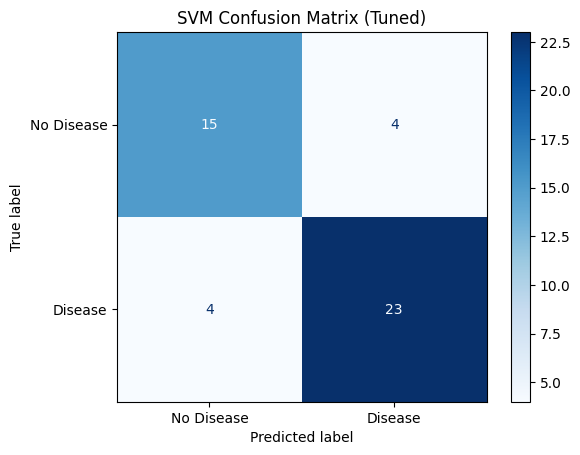

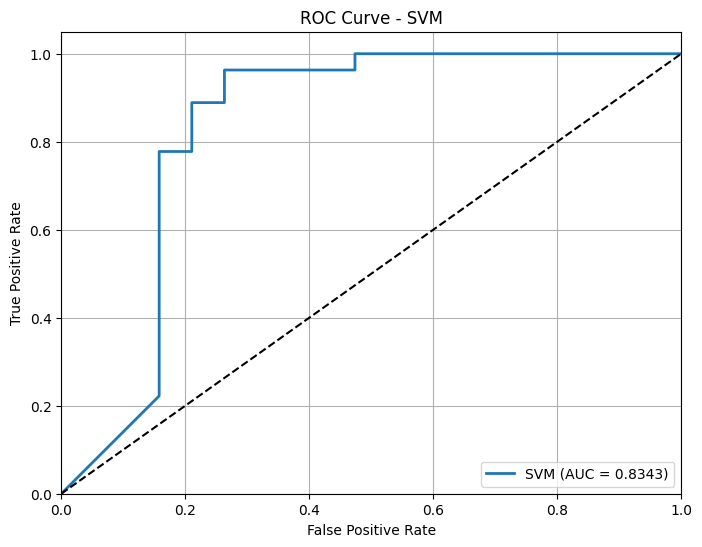


=== Proper Cross-Validation ===
SVM CV F1 Scores: [0.913  0.7083 0.9    0.8205 0.8636]
SVM Mean CV F1: 0.8411 +/- 0.1475

Overfitting Analysis:
Train Accuracy: 0.8306
Test Accuracy:  0.8261
Accuracy Gap:   0.0045
--- GOOD GENERALIZATION ---

✓ SVM model saved as 'svm_model.pkl'
✓ Scaler saved as 'svm_scaler.pkl'


In [2]:


# IT24103890 - SVM Model
from google.colab import files
uploaded = files.upload()

# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                           classification_report, roc_curve)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Loading the preprocessed dataset
df = pd.read_csv("heart_selected_features_final.csv")

# Preparing features and target
X = df.drop("target", axis=1)
y = df["target"]

print("Dataset shape:", X.shape)
print("Class distribution:\n", y.value_counts())

# Scale features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Define consistent CV strategy
CV_STRATEGY = 5
cv = StratifiedKFold(n_splits=CV_STRATEGY, shuffle=True, random_state=42)

# Hyperparameter tuning for SVM
print("\n=== SVM Hyperparameter Tuning ===")
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "kernel": ['linear', 'rbf', 'poly'],
    "gamma": ['scale', 'auto', 0.1, 0.01]
}

grid_svm = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    scoring="f1",
    cv=CV_STRATEGY,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)
print("Best Parameters for SVM:", grid_svm.best_params_)
print("Best CV Score (F1):", grid_svm.best_score_)

# Getting the tuned model
svm_model = grid_svm.best_estimator_

# Test set evaluation
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

print("\n=== SVM Performance (Test Set) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_proba_svm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['No Disease', 'Disease']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm),
                       display_labels=['No Disease', 'Disease']).plot(cmap="Blues")
plt.title("SVM Confusion Matrix (Tuned)")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
plt.plot(fpr, tpr, linewidth=2, label=f"SVM (AUC = {roc_auc_score(y_test, y_proba_svm):.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Proper Cross-Validation
print("\n=== Proper Cross-Validation ===")
svm_fresh = SVC(probability=True, random_state=42, **grid_svm.best_params_)
svm_cv_scores = cross_val_score(svm_fresh, X_train, y_train, cv=cv, scoring="f1")

print("SVM CV F1 Scores:", svm_cv_scores.round(4))
print("SVM Mean CV F1:", svm_cv_scores.mean().round(4), "+/-", (svm_cv_scores.std() * 2).round(4))

# Overfitting analysis
train_pred = svm_model.predict(X_train)
test_pred = y_pred_svm

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
accuracy_gap = abs(train_accuracy - test_accuracy)

print(f"\nOverfitting Analysis:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Accuracy Gap:   {accuracy_gap:.4f}")

if accuracy_gap > 0.05:
    print("--- POTENTIAL OVERFITTING ---")
else:
    print("--- GOOD GENERALIZATION ---")

# Save the model and scaler
import joblib
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(scaler, 'svm_scaler.pkl')
print("\n✓ SVM model saved as 'svm_model.pkl'")
print("✓ Scaler saved as 'svm_scaler.pkl'")